# Lab 0: Introduction to PyTorch

Welcome to COMSM0159 Advanced Visual AI (AVAI)!

The goal of this labsheet is to provide an introduction to [PyTorch](https://pytorch.org/). By the end of this lab, you should be able to do the following:
1. Recognise that there several ways to input/output images in PyTorch
2. Load and run inference using a pretrained model from Torchvision
3. Understand how to experiment with the latest models

We expect you to already know how to use Jupyter notebooks and create conda environments. If you don't, please go through these exercises:
- [Conda Introduction](https://conda.io/projects/conda/en/latest/user-guide/getting-started.html)
- [Jupyter Introduction](https://github.com/COMSM0045-Applied-Deep-Learning/labsheets/blob/master/lab-0-python-intro/2-jupyter.ipynb)

---

## Part 1: PyTorch basics

In this section, we will learn the following:
1. Loading images to PyTorch and saving images
2. Augmentations
3. Using a pretrained Torchvision model

To start off with, on your lab machines open a terminal and enter the following:
```
module load anaconda
```
This will load the necessary packages for you to get started with PyTorch.

In [2]:
import torch
import torchvision
from torchvision import transforms as T
import torchvision.transforms.functional as TF

from PIL import Image
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Loading images
In PyTorch, all data manipulated must be a Tensor. Here we will explore multiple ways to load images and how to convert them into a Tensor.

Torchvision has their own method to load images `torchvision.io.read_image()` but sometimes we want to apply some preprocessing to the images beforehand using a different package (e.g. OpenCV). These packages may not be able to process Tensors, and therefore, we will go over alternative methods to load images and convert them into Tensors.

**TASK 1:** Convert the following datatypes into a Tensor. Ensure the Tensor has shape `(C, H, W)` and in the form `RGB`. Note that some methods result in Tensors with the shape `(4, H, W)` and others with shape `(3, H, W)`, why may that be the case?

In [3]:
## TASK 1:

# Loading image1.png using PIL as a Tensor
image1_pil = Image.open("images/image1.png")

# Loading image1.png using OpenCV as a Tensor
image_tensor = cv2.imread("images/image1.png")

# Loading image1.png using scikit-image as a Tensor
skimage_tensor = skimage.io.imread("images/image1.png")

# Loading image1.npy using numpy as a Tensor
numpy_tensor = np.load("images/image1.npy")
print(numpy_tensor.shape)

(1026, 1282, 4)


### Augmentations
Augmentation is a technique used to artificially create new data for training. This involves transforming the images to create a "new" image, which can be done *online* or *offline*. Torchvision provides transformations that can be used for *online* data augmentation.

Torchvision transformations accept PIL image, Tensor image, or a batch of Tensor images.

Torchvision provides the function `Compose()` which allows you to chain multiple transforms together. Below is an example:
```
T.Compose([
    transforms.CenterCrop(10),
    transforms.ToTensor(),
])
```

**TASK 2:** Compose the following transformations: `RandomHorizontalFlip()`, `RandomRotation(10)` and `ToTensor()`. What do you notice about the values stored in the Tensor after this transformation? Which transformation caused this and why is it beneficial?

In [4]:
## TASK 2
img_pil = Image.open("images/image1.png")

# Compose the transform and apply to img_pil
img_transformed = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor()
])(img_pil)
print(img_transformed.shape)

torch.Size([4, 1026, 1282])


### Outputting images
Being able to visualise the Tensors is very important for numerous reasons (e.g. debugging). Here, we will go over several ways to output the images.

**TASK 3:** Output `img_transformed` with the several methods listed below.

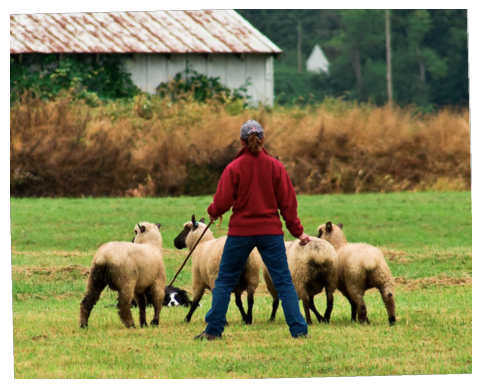

0.0 1.0 (1026, 1282, 4)


In [16]:
## TASK 3

# Displaying the image using Matplotlib
display = img_transformed.permute(1, 2, 0).numpy()
plt.imshow(display)
plt.axis("off")
plt.show()

# Displaying the image using PIL
display_PIL = TF.to_pil_image(img_transformed)
display_PIL.show()

# Displaying the image using OpenCV (Note: OpenCV uses BGR format)
display_cv = cv2.cvtColor(display, cv2.COLOR_RGB2BGR)
cv2.imshow("image", display_cv)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Saving the image using PIL
display_PIL.save("images/image_transformed.png")

# Saving the image using OpenCV
cv2.imwrite("images/image_transformed_cv.png", display_cv * 255)

# Saving the image using scikit-image
# transform the shape [4, 1026, 1282] to [1026, 1282, 4]
print(display.min(), display.max(), display.shape)
skimage.io.imsave("images/image_transformed_skimage.png", (display * 255).astype(np.uint8))

# Saving the image using numpy (no need to convert to 0-255 range)
np.save("images/image_transformed.npy", img_transformed.numpy())

### Using pretrained models from PyTorch

Torchvision provides code and pretrained weights for several popular deep learning models for a variety of computer vision tasks. For this exercise, we will be focusing on semantic segmentation, but feel free to try out other models listed [here](https://pytorch.org/vision/stable/models.html) in your free time.

**TASK 4:** Using the pretrained DeepLabV3 model, run inference on `images/image1.png`
*Hint:* you will need to ensure that the image has the right number of channels.

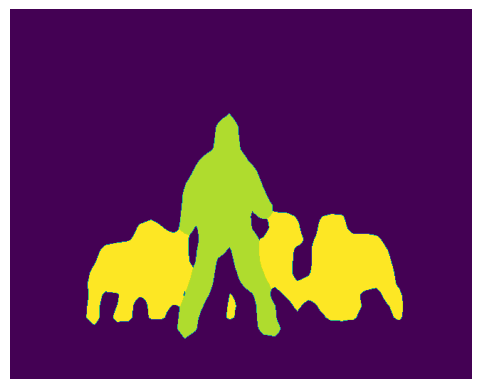

In [7]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights

# Initialize model with the pretrained weights
weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)
model.to(device)
model.eval()
preprocess = weights.transforms()

# Step 1: Load the image
img = Image.open("images/image1.png")
img = img.convert("RGB")

# Step 2: Apply inference preprocessing transforms
input_tensor = preprocess(img).unsqueeze(0).to(device)

# Step 3: Run inference using the model and visualize the prediction
with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0)
    plt.imshow(output_predictions.cpu().numpy())
    plt.axis("off")
    plt.show()

---

## Part 2: Experimenting with latest methods
Computer vision is an fast-growing field and the models provided by Torchvision are limited and are already outperformed. As a result, it is an important skill to be able to experiment with the latest methods.

In this section, we will experiment with Segment Anything 2 (SAM2) model, which is a foundational model for prompatable segmentation on videos: https://github.com/facebookresearch/segment-anything-2

**TASK 1:**
Follow the <u>Installation</u> instructions found in the repository's README to correctly download and install SAM2. *I highly recommend creating a new conda environment for this to avoid any conflicts*

Also, install the following packages: `scikit-image`, `opencv`, `matplotlib-pyplot`, (`ipykernel` if you haven't already.)

Then download the `sam2_hiera_large.pt` checkpoint and store in `./checkpoints`.

In [3]:
# Helper functions; used for visualisation
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders=True, obj_id=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    elif obj_id:
        cmap = plt.get_cmap("tab10")
        color = np.array([*cmap(obj_id)[:3], 0.6])
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

**TASK 2.1:**
Build a `SAM2ImagePredictor`, load in the checkpoint weights and set the input image.

**TASK 2.2:** 
Using SAM2, get the segmentation mask for the person. The input prompt is provided to you.
(<u>NOTE:</u> Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one.)

**TASK 2.3:** SAM2 takes in either points and/or boxes as input prompts - read through the documentation and try to figure out how to do this.

<div class="alert alert-block alert-danger">
<b>Warning:</b> SAM2 does not take Tensors as inputs, it takes in the following: np.ndarray, PILImage
</div>

In [27]:
# Image and prompts to pass into SAM2 model
image = Image.open('images/image1.png')
image = np.array(image.convert("RGB"))

input_point = np.array([[597, 523]])
input_box = np.array([445, 304, 792, 927])
input_label = np.array([1])

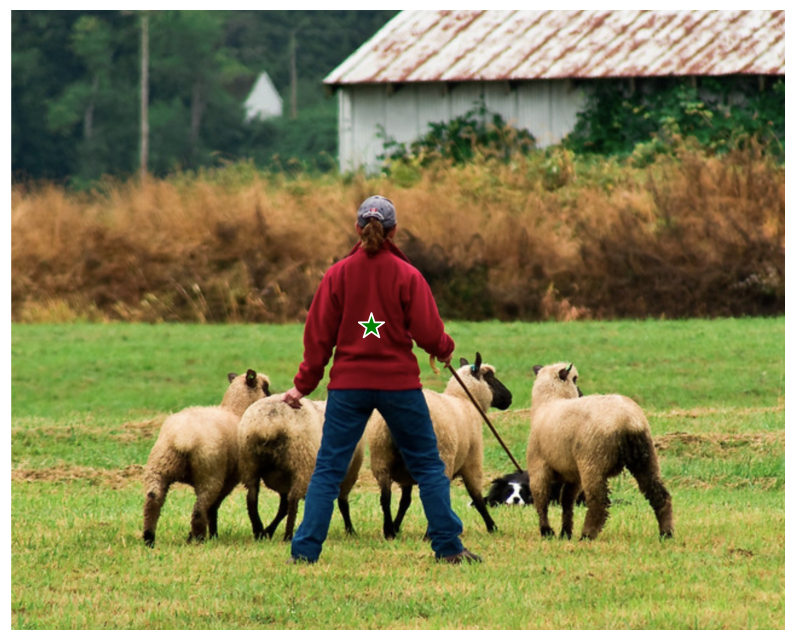

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis("off")
plt.show()

Masks found using point input:


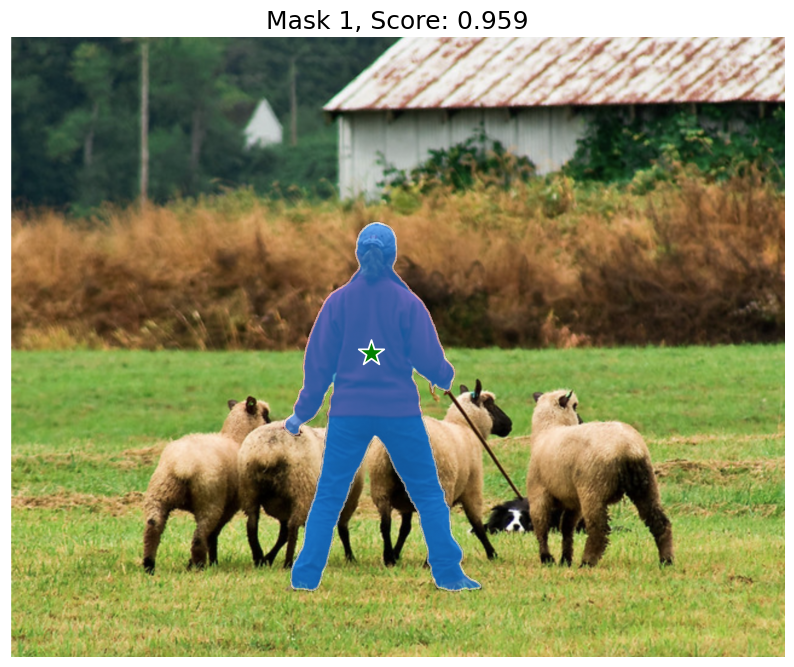

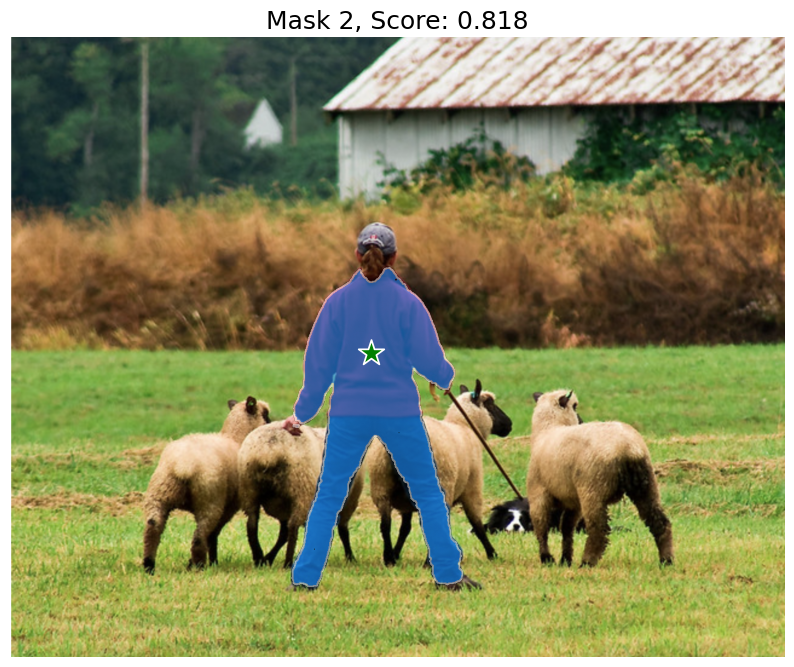

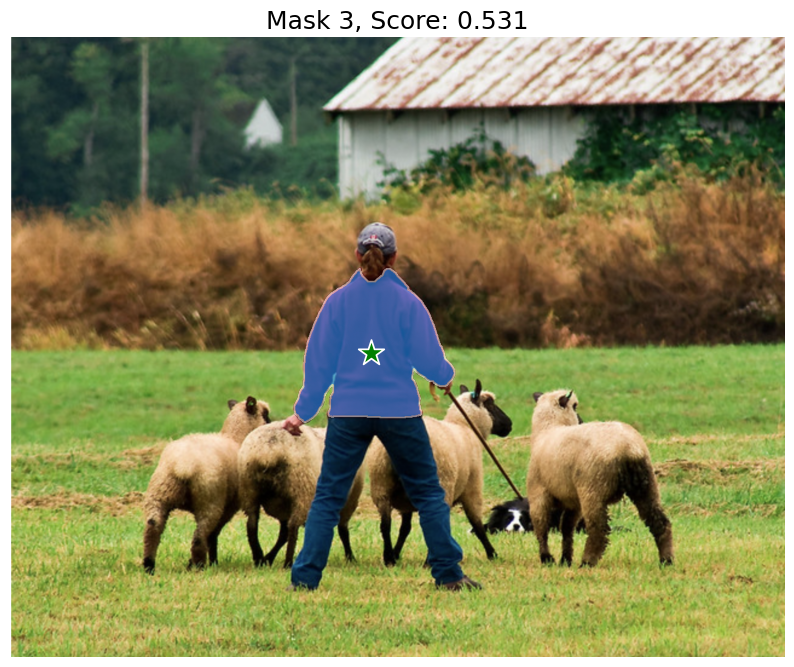

In [11]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
# device = "cuda"

## TASK 2.1:
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device = device)
predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image)

## TASK 2.2:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output = True,
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

print("Masks found using point input:")
show_masks(image, masks, scores, point_coords=input_point, input_labels=input_label)


Masks found using box input:


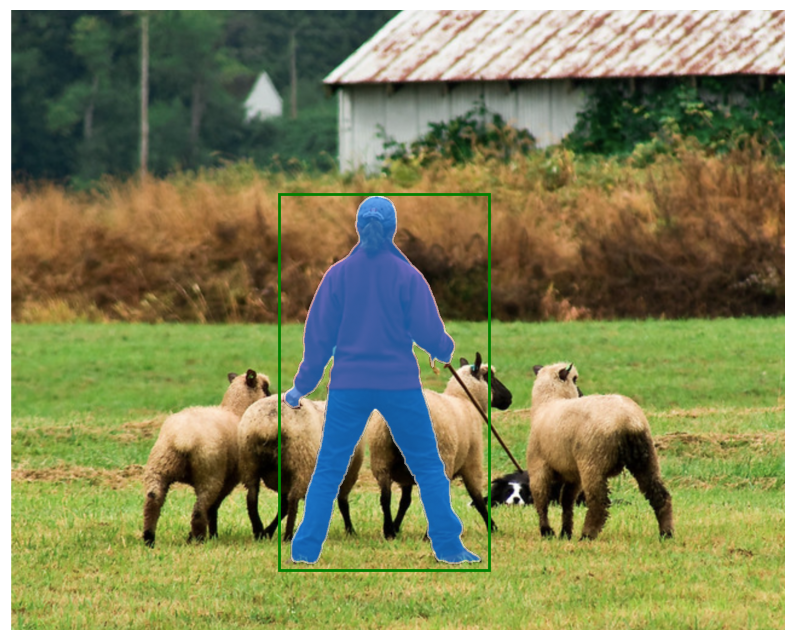

In [25]:
## TASK 2.3:
masks, scores, logits = predictor.predict(
    point_coords = None,
    point_labels = None,
    box = input_box[None, :],
    multimask_output = False,
)


print("Masks found using box input:")
show_masks(image, masks, scores, box_coords=input_box)

**TASK 3:**
SAM2 can also do end-to-end batch processing. This allows the SAM2 predictor to take a batch of prompts as inputs for multiple images. Look through the documentation and determine how to do this

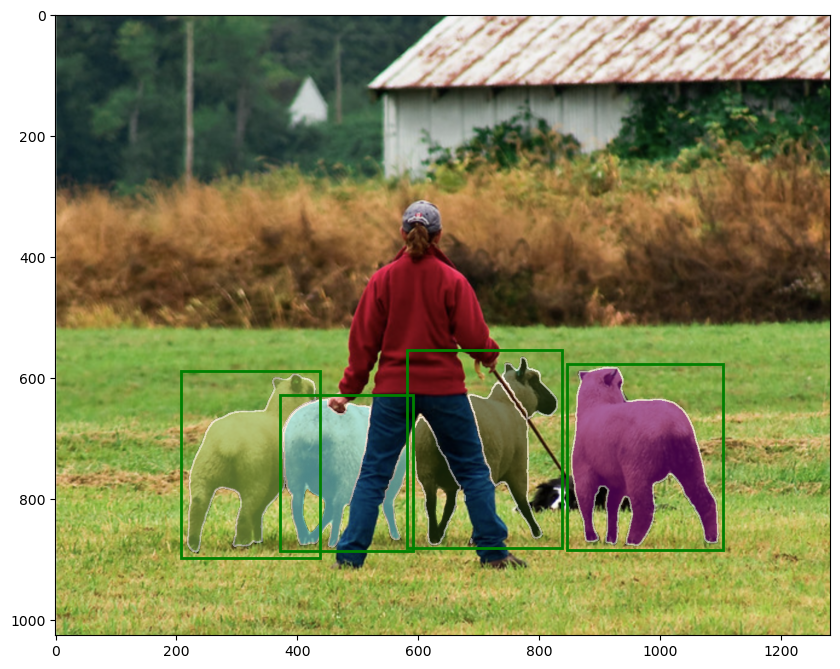

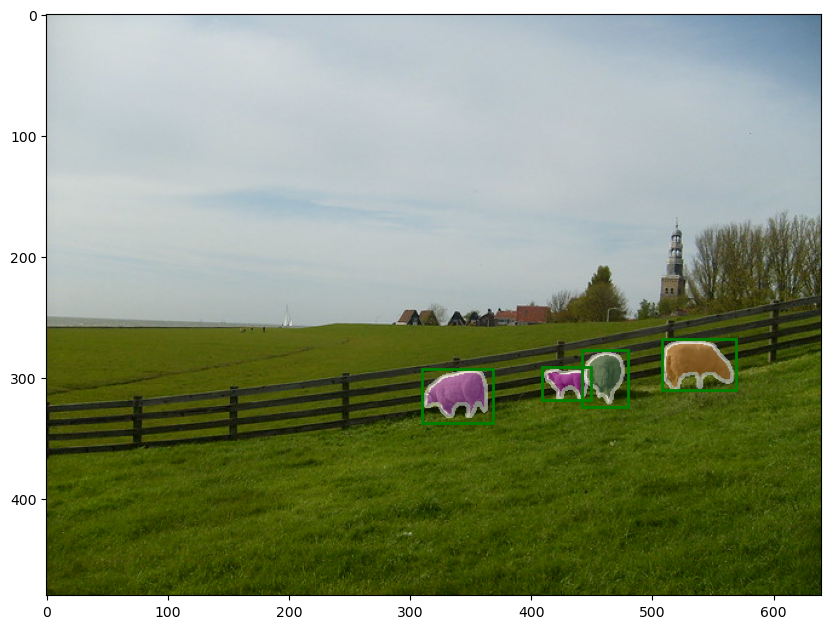

In [35]:
image1 = Image.open('images/image1.png')
image1 = np.array(image1.convert("RGB"))
image1_boxes = np.array([
    [208, 588, 437, 898],
    [372, 628, 591, 886],
    [581, 554, 838, 881],
    [846, 576, 1104, 885],
])

image2 = Image.open('images/image2.png')
image2 = np.array(image2.convert("RGB"))
image2_boxes = np.array([
    [310, 293, 368, 337],
    [409, 291, 449, 318],
    [442, 277, 480, 324],
    [508, 268, 569, 310],
])

img_batch = [image1, image2]
boxes_batch = [image1_boxes, image2_boxes]
predictor.set_image_batch(img_batch)
## TASK 3:
masks_batch, scores_batch, _ = predictor.predict_batch(
    None,
    None,
    box_batch = boxes_batch,
    multimask_output= False
)

# Display the outputs for image1 and image2 using the box prompts
for img, boxes, masks in zip(img_batch, boxes_batch, masks_batch):
    plt.figure(figsize=(10, 10))
    plt.imshow(img)   
    for mask in masks:
        show_mask(mask.squeeze(0), plt.gca(), random_color=True)
    for box in boxes:
        show_box(box, plt.gca())

### CHALLENGE:
SAM2 builds upon SAM buy allowing users to track masks in videos (rather than just images). You will need to first save the video as a folder of frames
(e.g. `ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'`). In this lab, we have already provided frames from our [BVI-RLV dataset](https://ieee-dataport.org/open-access/bvi-lowlight-fully-registered-datasets-low-light-image-and-video-enhancement). This dataset provides fully-registered low-light content with their corresponding normal-light condition.

<details>
    <summary>Side note</summary>
    Currently SAM2 only supports JPEG frames, the frames provided is a subset sampled from the original set of frames from the BVI-RLV dataset and saved as `.jpg` for compatibility.
</details>

 For this challenge, you will need to write code to track the object of interest (the wooden puzzle) in `normal_light_10`. Now try your code again on `low_light_10`. What do you notice about the outputs from SAM2?

> Note: if you have run any previous tracking using the inference_state, please reset it first via `reset_state()`.

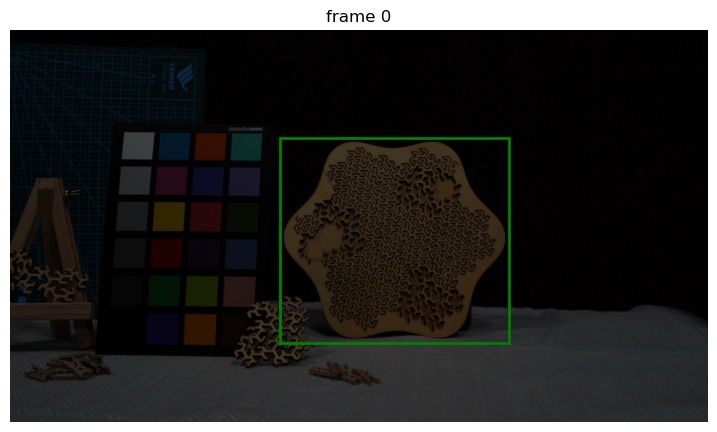

In [6]:
# NOTE: `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`

video_dir = "./video/input"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
frames = [Image.open(os.path.join(video_dir, p)) for p in frame_names]

# take a look the first video frame with the box prompt
frame_idx = 0
box = np.array([742, 298, 1374, 863], dtype=np.float32)

plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
plt.axis("off")
show_box(box, plt.gca())


**TASK 4.1**
First you will need to build a video predictor using the function `build_sam2_video_predictor()`. Using this predictor and the box given above, generate the mask for the *first* frame.

In [ ]:
from sam2.build_sam import build_sam2_video_predictor

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 4  # give a unique id to each object we interact with (it can be any integers)

## TASK 4.1:
predictor = None
inference_state = None
out_obj_ids, out_mask_logits = None, None

In [ ]:
# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
plt.axis("off")
show_box(box, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0], borders=False)

**TASK 4.2**
Once you have successfully generated a mask for the initial frame, propagate it throughout the video using `propagate_in_video()`. This will create masklets for the object throughout the entire video (masklets are similar to tracklets, where they store the associated identifier for each unique object, but instead of bounding boxes, it is segmentation masks).

In [31]:
# TASK 4.2: run propagation throughout the video and collect the results in a dictionary
video_segments = {}

propagate in video: 100%|██████████| 48/48 [00:13<00:00,  3.66it/s]


In [ ]:
# Render the segmentation results every 10 frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    plt.axis("off")
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id, borders=False)